***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_3_3')

FOLDER CREATED =  ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_3


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=7)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=10)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 32
    SCap_c_dims = 64


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), 
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 7)           0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 10)           0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None,)             0           ['prediction_medium[0][0]']      
 da)                                                                                              
          

 )                                                                                                
                                                                                                  
 tf.math.square_2 (TFOpLambda)  (None, 7)            0           ['tf.math.maximum_2[0][0]']      
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 7)           0           ['tf.math.subtract_9[0][0]']     
 a)                                                                                               
                                                                                                  
 tf.math.square_3 (TFOpLambda)  (None, 7)            0           ['tf.math.maximum_3[0][0]']      
                                                                                                  
 tf.math.reduce_sum_3 (TFOpLamb  (None,)             0           ['tf.math.multiply_2[0][0]']     
 da)      

 )                                                                                                
                                                                                                  
 tf.math.multiply_6 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]',               
 )                                                                'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 2)           0           ['tf.math.multiply_7[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.reduce_sum_7 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)                                                                                              
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.2058 - prediction_coarse_accuracy: 0.8822 - prediction_medium_accuracy: 0.5875 - prediction_fine_accuracy: 0.4520
  • Coarse Accuracy = 88.22% | Val_Accuracy = 90.97% | LossWeight = 0.17 
  • Medium Accuracy = 58.75% | Val_Accuracy = 66.24% | LossWeight = 0.42 
  • Fine   Accuracy = 45.20% | Val_Accuracy = 51.75% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.51750, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_3\epoch-best.h5
781/781 [==============================] - 148s 168ms/step - loss: 0.2058 - prediction_coarse_accuracy: 0.8822 - prediction_medium_accuracy: 0.5875 - prediction_fine_accuracy: 0.4520 - val_loss: 0.1644 - val_prediction_coarse_accuracy: 0.9097 - val_prediction_medium_accuracy: 0.6624 - val_prediction_fine_accuracy: 0.5175 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1233 - prediction_coarse_accuracy: 0.9252

781/781 [==============================] - ETA: 0s - loss: 0.0526 - prediction_coarse_accuracy: 0.9796 - prediction_medium_accuracy: 0.9449 - prediction_fine_accuracy: 0.9249
  • Coarse Accuracy = 97.96% | Val_Accuracy = 98.35% | LossWeight = 0.21 
  • Medium Accuracy = 94.49% | Val_Accuracy = 92.21% | LossWeight = 0.39 
  • Fine   Accuracy = 92.49% | Val_Accuracy = 88.81% | LossWeight = 0.40 

Epoch 18: val_prediction_fine_accuracy improved from 0.88430 to 0.88810, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_3\epoch-best.h5
781/781 [==============================] - 114s 146ms/step - loss: 0.0526 - prediction_coarse_accuracy: 0.9796 - prediction_medium_accuracy: 0.9449 - prediction_fine_accuracy: 0.9249 - val_loss: 0.0338 - val_prediction_coarse_accuracy: 0.9835 - val_prediction_medium_accuracy: 0.9221 - val_prediction_fine_accuracy: 0.8881 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0531 - prediction_coarse_accuracy: 0.9797 - 

781/781 [==============================] - ETA: 0s - loss: 0.0468 - prediction_coarse_accuracy: 0.9831 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9546
  • Coarse Accuracy = 98.31% | Val_Accuracy = 98.58% | LossWeight = 0.25 
  • Medium Accuracy = 96.27% | Val_Accuracy = 93.04% | LossWeight = 0.39 
  • Fine   Accuracy = 95.46% | Val_Accuracy = 90.04% | LossWeight = 0.36 

Epoch 36: val_prediction_fine_accuracy improved from 0.89970 to 0.90040, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_3\epoch-best.h5
781/781 [==============================] - 139s 178ms/step - loss: 0.0468 - prediction_coarse_accuracy: 0.9831 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9546 - val_loss: 0.0316 - val_prediction_coarse_accuracy: 0.9858 - val_prediction_medium_accuracy: 0.9304 - val_prediction_fine_accuracy: 0.9004 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0473 - prediction_coarse_accuracy: 0.9825 - 

781/781 [==============================] - ETA: 0s - loss: 0.0450 - prediction_coarse_accuracy: 0.9860 - prediction_medium_accuracy: 0.9663 - prediction_fine_accuracy: 0.9609
  • Coarse Accuracy = 98.60% | Val_Accuracy = 98.76% | LossWeight = 0.24 
  • Medium Accuracy = 96.63% | Val_Accuracy = 93.68% | LossWeight = 0.41 
  • Fine   Accuracy = 96.09% | Val_Accuracy = 90.83% | LossWeight = 0.35 

Epoch 54: val_prediction_fine_accuracy improved from 0.90770 to 0.90830, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_3\epoch-best.h5
781/781 [==============================] - 108s 139ms/step - loss: 0.0450 - prediction_coarse_accuracy: 0.9860 - prediction_medium_accuracy: 0.9663 - prediction_fine_accuracy: 0.9609 - val_loss: 0.0279 - val_prediction_coarse_accuracy: 0.9876 - val_prediction_medium_accuracy: 0.9368 - val_prediction_fine_accuracy: 0.9083 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0455 - prediction_coarse_accuracy: 0.9830 - 

781/781 [==============================] - 108s 138ms/step - loss: 0.0453 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9662 - prediction_fine_accuracy: 0.9604 - val_loss: 0.0275 - val_prediction_coarse_accuracy: 0.9881 - val_prediction_medium_accuracy: 0.9392 - val_prediction_fine_accuracy: 0.9116 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0447 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.9606
  • Coarse Accuracy = 98.45% | Val_Accuracy = 98.80% | LossWeight = 0.26 
  • Medium Accuracy = 96.56% | Val_Accuracy = 93.87% | LossWeight = 0.40 
  • Fine   Accuracy = 96.06% | Val_Accuracy = 91.09% | LossWeight = 0.34 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.91160
781/781 [==============================] - 103s 132ms/step - loss: 0.0447 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.960

781/781 [==============================] - 105s 134ms/step - loss: 0.0451 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9665 - prediction_fine_accuracy: 0.9608 - val_loss: 0.0269 - val_prediction_coarse_accuracy: 0.9883 - val_prediction_medium_accuracy: 0.9387 - val_prediction_fine_accuracy: 0.9101 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.0446 - prediction_coarse_accuracy: 0.9847 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.9614
  • Coarse Accuracy = 98.47% | Val_Accuracy = 98.80% | LossWeight = 0.26 
  • Medium Accuracy = 96.71% | Val_Accuracy = 93.89% | LossWeight = 0.39 
  • Fine   Accuracy = 96.14% | Val_Accuracy = 91.19% | LossWeight = 0.35 

Epoch 83: val_prediction_fine_accuracy did not improve from 0.91290
781/781 [==============================] - 108s 138ms/step - loss: 0.0446 - prediction_coarse_accuracy: 0.9847 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.961

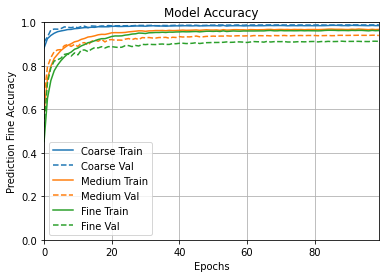

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

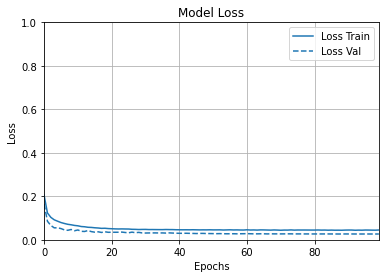

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 16s 41ms/step - loss: 0.0433 - prediction_coarse_loss: 0.0096 - prediction_medium_loss: 0.0447 - prediction_fine_loss: 0.0667 - prediction_coarse_accuracy: 0.9882 - prediction_medium_accuracy: 0.9396 - prediction_fine_accuracy: 0.9126
1. loss ==> 0.043272122740745544
2. prediction_coarse_loss ==> 0.00962905678898096
3. prediction_medium_loss ==> 0.04470863938331604
4. prediction_fine_loss ==> 0.06667866557836533
5. prediction_coarse_accuracy ==> 0.9882000088691711
6. prediction_medium_accuracy ==> 0.9395999908447266
7. prediction_fine_accuracy ==> 0.9125999808311462
313/313 [==============================] - 11s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

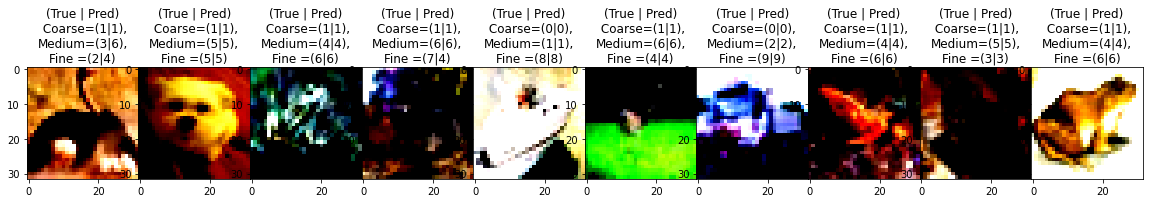

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3952   48]
 [  70 5930]]

  • MEDIUM LEVEL 
[[ 938   17   18   13    3    9    2]
 [  32  936   22    4    1    4    1]
 [  15   11 1967    1    1    4    1]
 [  29    1    0  885   17   38   30]
 [   4    2    5   17  941   26    5]
 [  11    2   11   43   29 1851   53]
 [   8    3    3   32   19   57 1878]]

  • FINE LEVEL 
[[941   7  14   4   1   1   3   0  19  10]
 [  3 965   1   0   1   1   0   0   4  25]
 [ 29   0 891  21  22  13  16   7   1   0]
 [  9   2  26 791  15 103  31  12   1  10]
 [  3   1  29  11 913  11  19  11   2   0]
 [  2   1  21  76  18 861   4  16   1   0]
 [  4   1  17  18   4   3 947   1   2   3]
 [  5   0   8  13  18  15   4 934   1   2]
 [ 31   7   4   3   1   0   1   0 940  13]
 [ 12  34   0   3   0   0   1   0   7 943]]

  • Classification Report 


  • COARSE LEVEL 


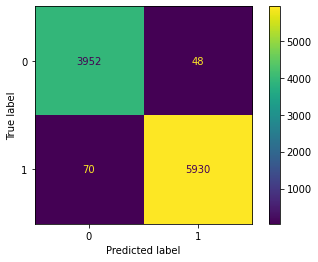

              precision    recall  f1-score   support

           0    0.98260   0.98800   0.98529      4000
           1    0.99197   0.98833   0.99015      6000

    accuracy                        0.98820     10000
   macro avg    0.98728   0.98817   0.98772     10000
weighted avg    0.98822   0.98820   0.98821     10000


  • MEDIUM LEVEL 


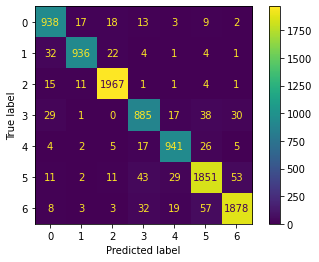

              precision    recall  f1-score   support

           0    0.90453   0.93800   0.92096      1000
           1    0.96296   0.93600   0.94929      1000
           2    0.97088   0.98350   0.97715      2000
           3    0.88945   0.88500   0.88722      1000
           4    0.93076   0.94100   0.93585      1000
           5    0.93062   0.92550   0.92805      2000
           6    0.95330   0.93900   0.94610      2000

    accuracy                        0.93960     10000
   macro avg    0.93464   0.93543   0.93495     10000
weighted avg    0.93973   0.93960   0.93959     10000


  • FINE LEVEL 


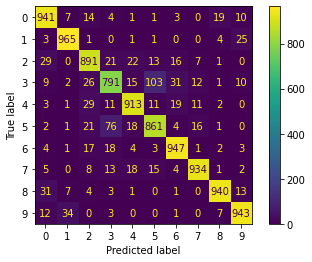

              precision    recall  f1-score   support

           0    0.90568   0.94100   0.92300      1000
           1    0.94794   0.96500   0.95639      1000
           2    0.88131   0.89100   0.88613      1000
           3    0.84149   0.79100   0.81546      1000
           4    0.91944   0.91300   0.91621      1000
           5    0.85417   0.86100   0.85757      1000
           6    0.92300   0.94700   0.93485      1000
           7    0.95209   0.93400   0.94296      1000
           8    0.96115   0.94000   0.95046      1000
           9    0.93738   0.94300   0.94018      1000

    accuracy                        0.91260     10000
   macro avg    0.91236   0.91260   0.91232     10000
weighted avg    0.91236   0.91260   0.91232     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9464816666666668 
Hierarchical Recall = 0.9481666666666666 
Hierarchical F1-Score = 0.9471916666666667 
Consistency =  0.9911 
Exact Match =  0.909
